In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.visualize import view
from ase.visualize.plot import plot_atoms
# from ase.build import graphene
from ase.io import read, write
from ase.atoms import Atoms
import seaborn as sb

sb.set_theme("notebook", "darkgrid")


from ase.spacegroup import crystal # Useful for setting up crystals

In [2]:
# Helper functions

def sort_atoms(atoms):
    # Use numpy.lexsort to sort by z, then y, then x
    pos = atoms.get_positions()
    sorted_indices = np.lexsort((pos[:, 2], pos[:, 1], pos[:, 0]))
    return atoms[sorted_indices]

def print_matrix(V):
    """
    Print the hopping matrix with row and column indices for better readability.
    
    Parameters:
        V: np.ndarray
            The N x N hopping matrix to print.
    """
    N = V.shape[0]
    # Print column headers
    header = "   " + " ".join(f"{j:8d}" for j in range(N))
    print(header)
    print("-" * len(header))
    
    # Print each row with row index and formatted values
    for i in range(N):
        row_values = " ".join(f"{V[i, j]:8.2f}" for j in range(N))
        print(f"{i:<3d} {row_values}")

# Define atomic structure for $\mathrm{ABO}_3$ perovskite oxide

In [3]:
a0 = 3.9 # Angstrom
oxide = crystal("SrVO3", basis=[[0.5,0.5,0.5], [0.,0.,0.], [0.5,0.,0.]], cellpar=a0, spacegroup=221) 
# Notice, only need to specify 1 oxygen atom the other oxygen sites are determined by spacegroup (221 in this case)

In [4]:
# view(oxide)

<Axes: >

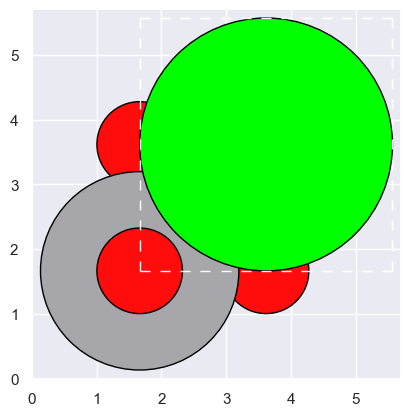

In [5]:
plot_atoms(oxide)

# Throw away atoms to simplify Hamiltonian

In [6]:
oxide = oxide[[atom.index for atom in oxide if atom.symbol=='V']] # Only keep vanadium (i.e., B site)
init_oxide_copy = oxide

In [7]:
view(oxide)

<Popen: returncode: None args: ['c:\\Users\\basti\\anaconda3\\envs\\10325\\p...>

Of course, in principle, we could have just defined our atom coordinates by hand since our resulting lattice is a simple cubic lattice.
But for more complex structures working with ASE crystal builders can be very useful.

# Task: Set up <u>bulk</u> Hamiltonian and calculate band structure

Now generate the (dxy, dyz, dxz) Hamiltonian for this bulk crystal. Then calculate the band structure between $\Gamma=(0,0,0)$, $X=(0.5,0,0)$, and $M=(0.5,0.5,0)$.

Start by making sure one of the orbitals is correct, e.g., dxy. There is no hopping between different orbitals!

Starting values to use: $\varepsilon = 0.6$ eV, $t_{ip} = -0.3$ eV, $t_{oop} = -0.03$ eV.

What happens if you include "diagonal" hopping with $t_{dia} = -0.1$ eV?

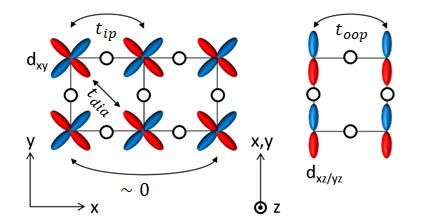

Reference band structure (including $t_{dia}$):

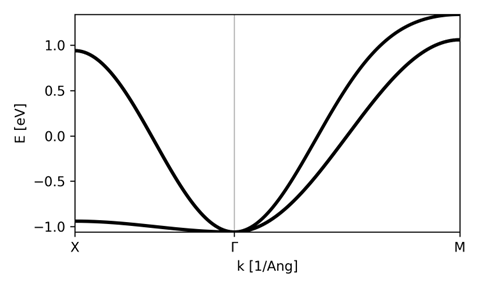

In [8]:
oxide = init_oxide_copy
cell = oxide.get_cell()
# oxide = oxide.repeat((2, 1, 1))
# oxide = oxide.repeat((1, 2, 1))
# oxide = oxide.repeat((1, 1, 2))
# oxide = sort_atoms(oxide)
write("oxide.xyz", oxide)
oxide_chain = init_oxide_copy
oxide_chain = oxide.repeat((5, 1, 1))
oxide_chain = oxide_chain.repeat((1, 2, 1))
oxide_chain.set_cell(cell)
write("oxide_chain.xyz", oxide)

array([[0., 0., 0.]])

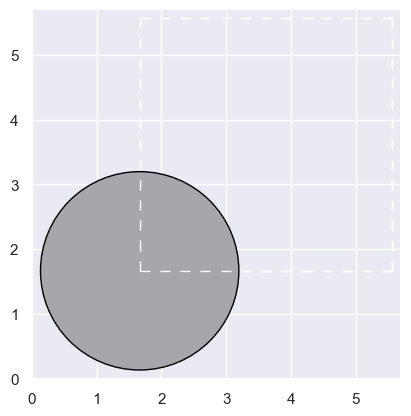

In [9]:
structure = read("oxide.xyz")

plot_atoms(structure)
xyz = structure.get_positions()
xyz


In [10]:
# def compute_dist(xyz1, xyz2):
#     return np.linalg.norm( xyz1[None, :, :] - xyz2[:, None, :], axis=2)

# def compute_hopping(xyz):
#     N, _ = xyz.shape # number of atoms
    

# def get_H(kx, ky, kz, xyz, **kwargs):
    
#     # Pad input k-vectors
#     kx = kx[:, None, None]
#     ky = ky[:, None, None]
#     kz = kz[:, None, None]
#     # define parameters
#     N, num_coords = xyz.shape
#     a = 3.9 # Å
#     eps = 0.6 # eV
#     t_ip = -0.3 # eV
#     t_diag = -0.1 # eV
#     t_oop = -0.01 # eV
    
#     # Initialize on-site and hopping matrices
#     h = np.zeros((N,N))
#     Vxy = np.zeros((N,N))
#     Vz = np.zeros((N,N))
    
#     # Compute interatomic distances
#     distances = compute_dist(xyz, xyz)
    
#     # on-site
#     h = np.zeros((N,N))
#     np.fill_diagonal(h, eps)
    
#     z_diff = np.abs(xyz[None, :, 2] - xyz[:, None, 2]) # Pairwise z-coordinate difference  
      
#     ## Apply conditions for same-plane interactions
#     same_plane = (z_diff == 0) # Boolean mask for same z-plane
#     # 1st NN
#     Vxy = np.where( (0.1 < distances ) & (distances < a + 0.1) & same_plane, t_ip, Vxy)
#     # # 2nd NN
#     # Vxy = np.where( (a + 0.1 < distances) & (distances < np.sqrt(2)*a + 0.1) & same_plane, t_diag, Vxy)
    
#     # Apply conditions for different-plane interactions
#     different_plane = ~same_plane # NOT operator elementwise
#     Vz = np.where( (0.1 < distances ) & (distances < a + 0.1) & different_plane, t_oop, Vz)
    
#     Vxy_phase  = Vxy * np.exp(1.j*kx) + np.conj(Vxy.T) * np.exp(-1.j*kx)
#     Vxy_phase += Vxy * np.exp(1.j*ky) + np.conj(Vxy.T) * np.exp(-1.j*ky)
    
#     Vz_phase   = Vz * np.exp(1.j*kz) + np.conj(Vz.T) * np.exp(-1.j*kz)
    
#     if kwargs.get("verbose", False):
#         print(f"{a + 0.1 = }")
#         print("distances = ")
#         print_matrix(distances)
#         print()
#         print("Vxy = ")
#         print_matrix(Vxy)
#         print()
#         print("Vz = ")
#         print_matrix(Vz)
#         print()
        
#     return h[None, :, :] + Vxy_phase + Vz_phase

# ks = np.linspace(-np.pi, np.pi, num=10)
# H = get_H(ks, ks, ks, xyz,  verbose=True)


In [11]:
def compute_H(k_vec, include_diag=True):
    kx, ky, kz = k_vec.T
    a = 3.9 # Å
    # t_ip   = np.array([[-0.3]], dtype=np.complex128) # Å
    # t_diag = np.array([[-0.1]], dtype=np.complex128) # Å
    # t_oop  = np.array([[-0.03]], dtype=np.complex128) # Å
    # eps    = np.array([[ 0.6]], dtype=np.complex128) # eV
    t_ip = -0.3   # Å
    t_diag = -0.1 # Å
    t_oop = -0.03 # Å
    eps = 0.6     # Å
    N = kx.shape[0]
    Ny = ky.shape[0]
    Nz = kz.shape[0]
    assert (N == Ny) & (N == Ny), f"length does not match:\nSizes are not equal: {N}, {Ny}, {Nz}."
    
    # construct Hamiltonian
    H = np.zeros((N, 3), dtype=np.complex128)
    ip_x = t_ip*np.exp(1j*2*np.pi*kx)
    ip_y = t_ip*np.exp(1j*2*np.pi*ky)
    ip_z = t_ip*np.exp(1j*2*np.pi*kz)
    if include_diag:
        diag_xy = t_diag*np.exp(1j*2*np.pi*(kx+ky))
        diag_yz = t_diag*np.exp(1j*2*np.pi*(ky+kz))
        diag_xz = t_diag*np.exp(1j*2*np.pi*(kx+kz))
    else:
        diag_xy = diag_yz = diag_xz = 0
    oop_x = t_oop*np.exp(1j*2*np.pi*kx)
    oop_y = t_oop*np.exp(1j*2*np.pi*ky)
    oop_z = t_oop*np.exp(1j*2*np.pi*kz)
    
    ## compute the orbitals in separate columns
    # dxy
    H[:, 0] += (ip_x + ip_y) + oop_z + (diag_xy)
    H[:, 0] += np.conj(H[:, 0])
    
    
    # dyz
    H[:, 1] += (ip_y + ip_z) + oop_x + (diag_yz)
    H[:, 1] += np.conj(H[:, 1])
    
    # dxz
    H[:, 2] += (ip_x + ip_z) + oop_y + (diag_xz)
    H[:, 2] += np.conj(H[:, 2])
    
    H += eps
    
    # check that the imaginary part is negligible
    assert np.all(np.isclose(H.imag, np.zeros_like(H.imag))), "Non negligible imagniary part"
    return np.real(H)

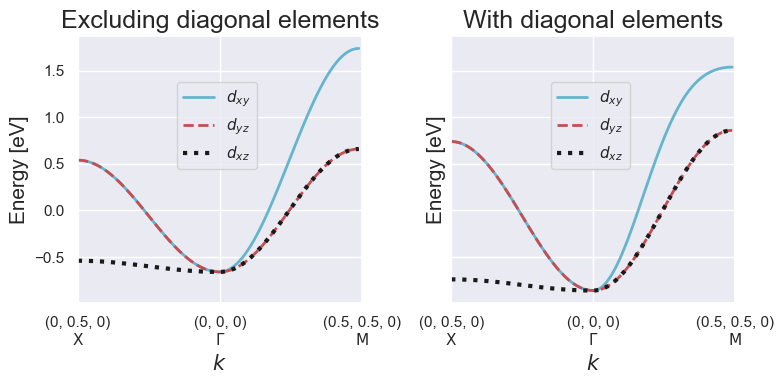

In [79]:
num_k = 50 # number of k points in x, y, and z

# Set crystal points
GAMMA = (0, 0, 0)
X = (0, 0.5, 0)
M = (0.5, 0.5, 0)

# Define path from X to GAMMA (exlcuding endpoint, as the next will start at GAMMA)
k_vec1 = np.linspace(X, GAMMA, num=num_k, endpoint=False)
# Define path from GAMMA to M
k_vec2 = np.linspace(GAMMA, M, num=num_k)
# Combine k-vectors
k_vec = np.concatenate((k_vec1, k_vec2), axis=0)

# compute Hamiltonian
H = compute_H(k_vec)

# Initialize figure
fig, axes = plt.subplots(1,2, figsize=(8,4), sharey=True)
# plotting parameters
line_styles = ["-", "--", ":"]
labels = [r"$d_{xy}$", r"$d_{yz}$", r"$d_{xz}$"]
colors = ["c", "r", "k"]
lws = [2, 2, 3]

# plot the eigenvalues with and w/o diagonal jumps.
for idx in range(H.shape[1]):
    axes[0].plot(compute_H(k_vec, include_diag=False)[:, idx], ls=line_styles[idx], label=labels[idx], color=colors[idx], lw=lws[idx])
    axes[1].plot(compute_H(k_vec, include_diag=True )[:, idx], ls=line_styles[idx], label=labels[idx], color=colors[idx], lw=lws[idx])

# set labels for x and y
for ax in axes:
    ax.set(xticks=[0, len(H)//2, len(H)],
        xticklabels=[f"{X}\n"+r"$\mathrm{X}$", f"{GAMMA}\n"+r"$\Gamma$", f"{M}\n"+r"$\mathrm{M}$"],
        xlabel="$k$",
        ylabel="Energy [eV]",
        xlim=(0,len(H)),
        # ylim=(-0.9, 1.8)
        )
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.legend(loc=(0.35, 0.5))
    
# Set suptitle on each plot
axes[0].set_title("Excluding diagonal elements", size=18)
axes[1].set_title("With diagonal elements", size=18)
fig.tight_layout()
None

# Create slabs (or membranes) from bulk crystals

<Axes: >

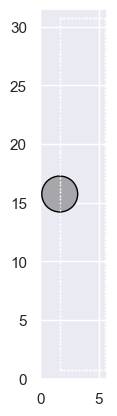

In [141]:
thickness = 1 # Vary thickness
oxide_slab = oxide.repeat((1,thickness,1)) # Repeat bulk system in one direction to create a thickness
# oxide_slab = oxide_slab.repeat((2,1,1)) # Repeat bulk system in one direction to create a thickness
# oxide_slab = oxide_slab.repeat((1,1,2)) # Repeat bulk system in one direction to create a thickness
oxide_slab.center(vacuum=15, axis=1) # Add vacuum for visualization

plot_atoms(oxide_slab)

# Task: Set up <u>slab</u> Hamiltonian and calculate band structure

From the slab geometry, construct Hamiltonians and calculate band structures. The major difference is that the states at the top/bottom surfaces of the slabs have no states to couple to. Implement this breaking of periodicity.

Note: keep periodic boundary conditions in the two other directions!

Study and understand the band structure. What is the role of the thickness?

In [109]:
def compute_dist(xyz1, xyz2):
    return np.linalg.norm( xyz1[None, :, :] - xyz2[:, None, :], axis=2)

In [13]:
def tile(atoms, ntile, axis):
    xyz = atoms.get_positions()
    cell = atoms.get_cell()
    xyz = xyz[None, ...].copy()
    xyz = xyz + cell[None, (axis,), :] * np.arange(ntile)[:, None, None]
    cell = cell.copy()
    cell[axis, :] *= ntile
    return xyz.reshape(-1, 3), cell

def repeat_atom(atoms, ntile, axis):
    xyz, cell = tile(atoms, ntile, axis)
    symbols = atoms.get_chemical_symbols()
    return Atoms(symbols*len(xyz), xyz, cell=cell)

def hamiltonian(xyz1, xyz2, lower, upper):
    dist = compute_dist(xyz1, xyz2)
    return np.where( (lower < dist) & (dist < upper), 1, 0)

def repeated_H(repeated_structure, oop_axis):
    
    # parameters
    a = 3.9         # Å
    eps = 0.6       # eV
    t_ip = -0.3     # eV
    t_diag = -0.1   # eV
    t_oop = -0.01   # eV
    num_atoms = len(repeated_structure) # number of atoms, number of dimension (not used)
    N = num_atoms // 2 # integer division (rounded down) Number of index to "skip" when retrieving on-site and hopping matrix
    xyz = repeated_structure.get_positions()
    
    # compute distance in "out-of-plane" direction
    oop_distance = np.abs(xyz[None, :, oop_axis] - xyz[:, None, oop_axis])
    
    # Create boolean mask
    same_plane = (oop_distance == 0)
    same_plane = True
    
    # compute distance to generate hamiltonian of repeated structure
    dist = compute_dist(xyz, xyz)
    H_repeated = eps*np.eye(num_atoms)
    H_repeated = np.where( (0.1 < dist) & (dist < (a + 0.1)) & same_plane, t_ip, H_repeated)
    H_repeated = np.where( (a + 0.1 < dist) & (dist < np.sqrt(2)*a + 0.1) & same_plane, t_diag, H_repeated)
    
    # for out-of-plane 
    different_plane = ~ same_plane # element-wise NOT operator
    different_plane = True
    H_repeated = np.where( (0.1 < dist) & (dist < (a + 0.1)) & different_plane, t_oop, H_repeated)
    
    ##  H_repeated =    |   h  ,   V^dagger  |
    ##                  |   V  ,      h      |
    ##
    # second row, first column
    V = H_repeated[N:, :N]
    # first fow, first column
    h = H_repeated[:N, :N]
    return h, V

def get_h(repeated_structure, oop_axis):
    N = len(repeated_structure)
    H = repeated_H(repeated_structure, oop_axis)
    return H[:N, :N]

def get_V(repeated_structure, oop_axis):
    N = len(repeated_structure)
    H = repeated_H(repeated_structure, oop_axis)
    return H[N:, :N]

# generate_hV(oxide_slab.repeat((2,1,1)), 2)
# view(repeat_atom(oxide_slab, 1, 0))


In [156]:
# number of k points in x, y, and z
num_k = 50 
# Set crystal points
GAMMA = (0, 0, 0)
X = (0, 0.5, 0)
M = (0.5, 0.5, 0)
# Define path from X to GAMMA (exlcuding end-point, as the next will start at GAMMA)
k_vec1 = np.linspace(X, GAMMA, num=num_k, endpoint=False)
# Define path from GAMMA to M
k_vec2 = np.linspace(GAMMA, M, num=num_k)
# Combine k-vectors
k_vec = np.concatenate((k_vec1, k_vec2), axis=0)

def hamiltonian_PBC(structure, k_vec):
    kx, ky, kz = k_vec.T
    kx = kx[:, None, None]
    ky = ky[:, None, None]
    kz = kz[:, None, None]
    num_kpoints = k_vec.shape[0]
    N = len(structure)  # equivalent to `structure.get_number_of_atoms()`
    
    # # initialize orbital hamiltonians
    # H_dxy = np.zeros(shape=(num_kpoints, N, N), dtype=np.complex128)
    # H_dyz = H_dxy.copy()
    # H_dxz = H_dxy.copy()
    
    
    repeated_structure = repeat_atom(structure, 2, 0)
    onsite = get_h(repeated_structure, oop_axis=0)
    
    V_x = get_V(repeated_structure, oop_axis=)
    
    # h_x, V_x = generate_hV(structure.reapeat((2,1,1)), axis=2)
    
    # h_y, V_y = generate_hV(structure.repeat((1,2,1)), axis=0)
    
    


1

In [118]:
oxide_slab = sort_atoms(oxide_slab)
xyz = oxide_slab.get_positions()

def get_H(k_vec, xyz, include_diag=True):
    
    # Pad input k-vectors
    kx, ky, kz = k_vec.T
    kx = kx[:, None, None]
    ky = ky[:, None, None]
    kz = kz[:, None, None]
    num_k = k_vec.shape[0]
    
    # define parameters
    N, _num_dim = xyz.shape # number of atoms, number of dimension (not used)
    a = 3.9         # Å
    eps = 0.6       # eV
    t_ip = -0.3     # eV
    t_diag = -0.1   # eV
    t_oop = -0.01   # eV
    
    # Initialize on-site and hopping matrices
    h = np.zeros((N,N), dtype=np.complex128)
    V_ip = np.zeros((N,N), dtype=np.complex128)
    V_diag = np.zeros((N,N), dtype=np.complex128)
    V_oop = np.zeros((N,N), dtype=np.complex128)
    
    #initilize output hamiltonian
    H_dxy = np.zeros(shape=(num_k, N, N), dtype=np.complex128)
    H_dyz = np.zeros(shape=(num_k, N, N), dtype=np.complex128)
    H_dxz = np.zeros(shape=(num_k, N, N), dtype=np.complex128)
    
    # Compute interatomic distances
    distances = compute_dist(xyz, xyz)
    
    # on-site matrix 
    np.fill_diagonal(h, eps)
    
    # Pairwise z-coordinate difference
    z_diff = np.abs(xyz[None, :, 2] - xyz[:, None, 2])
    
    ## Apply conditions for in-plane interactions
    same_plane = (z_diff == 0) # Boolean mask for same z-plane
    
    # 1st NN
    V_ip = np.where( (0.1 < distances ) & (distances < a + 0.1) & same_plane, t_ip, V_ip)
    # 2nd NN
    V_diag = np.where( (a + 0.1 < distances) & (distances < np.sqrt(2)*a + 0.1) & same_plane, t_diag, V_diag)
    
    # Apply conditions for out-of-plane interactions
    different_plane = ~ same_plane # elementwise NOT operator to invert Boolean mask
    V_oop = np.where( (0.1 < distances ) & (distances < a + 0.1) & different_plane, t_oop, V_oop)
    
    # define parameters shorthands
    ip_x = V_ip * np.exp(1j*2*np.pi*kx)
    ip_y = V_ip * np.exp(1j*2*np.pi*ky)
    ip_z = V_ip * np.exp(1j*2*np.pi*kz)
    if include_diag is True:
        diag_xy = V_diag*np.exp(1j*2*np.pi*(kx + ky))
        diag_yz = V_diag*np.exp(1j*2*np.pi*(ky + kz)) 
        diag_xz = V_diag*np.exp(1j*2*np.pi*(kx + kz))
    elif include_diag is False:
        diag_xy = diag_yz = diag_xz = 0
    oop_x = V_oop*np.exp(1j*2*np.pi*kx)
    oop_y = V_oop*np.exp(1j*2*np.pi*ky)
    oop_z = V_oop*np.exp(1j*2*np.pi*kz)
    
    # compute hamiltonian for each orbital
    # dxy
    H_dxy += ip_x + ip_y + diag_xy +  oop_z
    H_dxy += np.conjugate(np.transpose(H_dxy, axes=(0, 2, 1)))
    
    # dyz
    H_dyz += ip_y + ip_z + diag_yz +  oop_x
    H_dyz += np.transpose(np.conj(H_dyz), axes=(0, 1, 2))
    
    # dxz
    H_dxz += ip_x + ip_z + diag_xz +  oop_y
    H_dxz += np.transpose(np.conj(H_dxz), axes=(0, 1, 2))
    
    H_dxy += h[None, :, :]
    H_dxy += h[None, :, :]
    H_dxy += h[None, :, :]
    
    with np.printoptions(linewidth=140):
        print("V_oop = ")
        print(h)
        print()
        
        print("V_ip = ")
        print(V_ip)
        print()
        
    return np.array((H_dxy, H_dyz, H_dxz)) # size (3, num_k, N, N)

def get_eigs(k_vec, xyz, include_diag=True):
    H = get_H(k_vec, xyz, include_diag=include_diag)
    H_dxy, H_yz, H_xz = H
    
    return np.linalg.eigvalsh(H)

_ = get_H(k_vec, xyz)

V_oop = 
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

V_ip = 
[[ 0. +0.j -0.3+0.j  0. +0.j  0. +0.j  0. +0.j]
 [-0.3+0.j  0. +0.j -0.3+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.3+0.j  0. +0.j -0.3+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0.3+0.j  0. +0.j -0.3+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.3+0.j  0. +0.j]]



V_oop = 
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

V_ip = 
[[ 0. +0.j -0.3+0.j  0. +0.j  0. +0.j  0. +0.j]
 [-0.3+0.j  0. +0.j -0.3+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.3+0.j  0. +0.j -0.3+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0.3+0.j  0. +0.j -0.3+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.3+0.j  0. +0.j]]



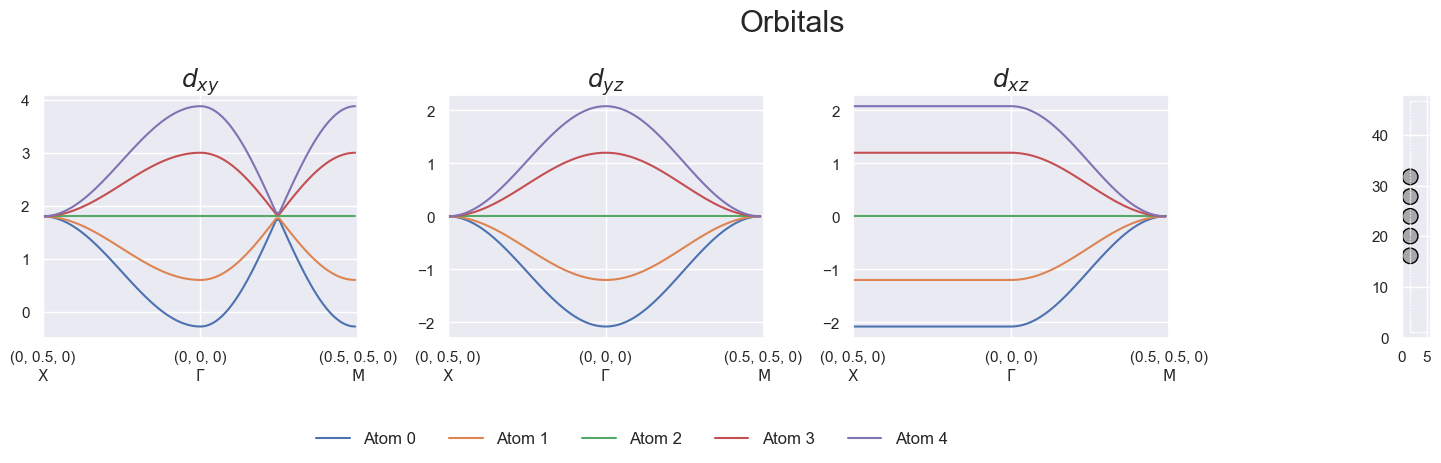

In [119]:
# H = get_H(k_vec, xyz)
eigs = get_eigs(k_vec, xyz)

fig, axes = plt.subplots(1,4, figsize=(16,4))
fig.suptitle("Orbitals", size=22)
title = [r"$d_{xy}$", r"$d_{yz}$", r"$d_{xz}$"]
for idx, ax in enumerate(axes[:3]):
    ax.plot(eigs[idx, ...])
    ax.set_title(title[idx], size=18)
    ax.set(xticks=[0, eigs.shape[1]//2, eigs.shape[1]],
           xticklabels=[f"{X}\n"+r"$\mathrm{X}$", f"{GAMMA}\n"+r"$\Gamma$", f"{M}\n"+r"$\mathrm{M}$"],
           xlim=(0, eigs.shape[1])
           )

fig.legend([f"Atom {i}" for i in range(eigs.shape[-1])], loc="lower center", ncols=eigs.shape[-1], frameon=False, fontsize=12, 
           bbox_to_anchor=(0.4, -0.15)
           )
plot_atoms(oxide_slab, ax=axes[3])
fig.tight_layout()

# Task: Transport in pristine bulk and slabs

Now that you can construct Hamiltonians and the band structures make sense, you can calculate the $\vec{k}$ and energy-resolved transmission as in the lecture notes/exercises.

Start with bulk systems and evaluate $T(E, k_x, k_y)$ with transport in $z$-direction.

Then continue with slabs and evaluate $T(E, k_x)$ with transport in $z$-direction and normal of slab along the $y$-axis.

# Task: Modify system with defects and/or layer-dependent onsite energies

In experiments there are additional mechanisms affecting the electrons. Let's see how the band structure and transmission is modified when defects and additional potentials are introduced. Feel free to focus on one or the other!

#### Oxygen vacancies:
A common defect in oxides are missing oxygen atoms. While the conduction is mainly done by the B-site (here vanadium) $d$-states, the O $2p$-states act as bridges between B-sites. Therefore, an oxygen vacancy lowers the magnitude of the hopping terms $|t|$. Introduce an oxygen vacancy, by modifying the hopping terms between two sites in the central device. How is the transmission affected?

#### Layer-dependent onsites:
From experiments and density functional theory calculations it has been observed that there is a layer-dependency of the electronic structure of oxide surfaces and membranes. E.g., in SrTiO$_3$ the electronic properties is drastically different near the surface, compared to deeper into the membranes. The origin can be either defects or interaction between the oxide membrane and the surroundings.

Introduce a layer-dependency to the onsites, i.e., $\varepsilon \rightarrow \varepsilon + V(y)$ where $y$ is the axis normal to the slab. Play around with the shape of the potential, $V(y)$. A starting point is to increase the onsite energy by $\sim 0.05$ eV/unit cell. You can apply this potential to the whole slab (including the electrode regions) or only to the central region. How is the transmission and band structure modified?


# Task: Bond currents

Read the lecture notes, and try to calculate the bond currents in some of the systems above. Start simple (no defects/potentials) in bulk or slabs.
Then move on to more complex systems and study how the current paths are modified by defects/potentials.